#Student Name: Ya Liu
#Student ID: 34540962
#FIT5217 Assignment 2
##Baseline 1: Sequence-to-Sequence model without attention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/ColabNotebooks/Cooking_Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- 1. IMPORTS ORGANIZATION ---
import os
import json
import re
import time
import math
import random
from io import open
import unicodedata
import string
from collections import Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud

!pip install nltk bert-score
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score

import logging
import transformers
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


In [ ]:
# --- 2. CONSOLIDATED HYPERPARAMETERS ---
# Special tokens
SOS_token = 0
EOS_token = 1
UNK_token = 2
PAD_token = 3

# Model hyperparameters
MAX_LENGTH = 100
HIDDEN_SIZE = 256
BATCH_SIZE = 16
LEARNING_RATE = 0.001
TEACHER_FORCING_RATIO = 0.5
NUM_EPOCHS = 30
PRINT_EVERY = 625
PLOT_EVERY = 625
PATIENCE = 5

# Training data limitation
MAX_TRAIN_SAMPLES = 10000  # Only use first 10000 samples from training set

# Development mode flag
USE_SMALL_TEST = False  # Use a small test set during development

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 3. NLTK SETUP ---
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

Using device: cuda


True

In [ ]:
# --- 4. LANGUAGE CLASS FOR VOCABULARY ---
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2, "PAD": 3}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK", 3: "PAD"}
        self.n_words = 4  # Count SOS, EOS, UNK and PAD

    def addSentence(self, sentence):
        # Add all words in a sentence to the vocabulary
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Add a single word to the vocabulary
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# --- 5. TEXT PREPROCESSING FUNCTIONS ---
def unicodeToAscii(s):
    # Convert Unicode string to ASCII
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    # Lowercase, trim, and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

def loadData(file_path, file_name, preprocess=True):
    # Load and preprocess data from CSV file
    print(f"Loading data from {file_path}/{file_name}")
    data = pd.read_csv(f"{file_path}/{file_name}")

    # Print the original data (before preprocessing) - only first 3 rows
    print(f"\nOriginal data from {file_name} (first 3 rows):")

    # Display original data with more columns - using pandas options to expand display
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 150)  # Wider display
    pd.set_option('display.max_colwidth', 100)  # Show more content in each cell

    print(data.head(3))

    # Convert ingredients from string representation to actual list
    data['Ingredients'] = data['Ingredients'].apply(eval)

    # Join ingredients into a single string
    data['Ingredients_text'] = data['Ingredients'].apply(lambda x: ' '.join(x))

    if preprocess:
        # Only normalize if preprocess is True
        data['Ingredients_norm'] = data['Ingredients_text'].apply(normalizeString)
        data['Recipe_norm'] = data['Recipe'].apply(normalizeString)

        # Print the preprocessed data - only first 3 rows
        print(f"\nPreprocessed data from {file_name} (first 3 rows):")
        print(data[['Ingredients_norm', 'Recipe_norm']].head(3))

    # Reset pandas display options to default
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

    return data

  # Load and preprocess data
train_data = loadData(file_path, "train.csv", preprocess=True)
dev_data = loadData(file_path, "dev.csv", preprocess=True)
test_data = loadData(file_path, "test.csv", preprocess=False)

# Create vocabularies
input_lang = Lang("ingredients")
output_lang = Lang("recipes")

# Limit training data to the first 10000 samples
train_data_limited = train_data.iloc[:MAX_TRAIN_SAMPLES].copy()
print(f"\nUsing the first {len(train_data_limited)} samples from the training set")
print(f"This is {len(train_data_limited)/len(train_data)*100:.1f}% of the complete training set")

# Add words from limited training data to vocabularies
print("Creating vocabularies from limited training data...")
for i, row in train_data_limited.iterrows():
    input_lang.addSentence(row['Ingredients_norm'])
    output_lang.addSentence(row['Recipe_norm'])

Loading data from /content/drive/MyDrive/ColabNotebooks/Cooking_Dataset/train.csv

Original data from train.csv (first 3 rows):
                  Title                                                                                          Ingredients  \
0   No-Bake Nut Cookies  ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken ...   
1           Creamy Corn  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg. cream cheese, cubed", "1/3 c. butter, cubed", "1...   
2  Reeses Cups(Candy)    ["1 c. peanut butter", "3/4 c. graham cracker crumbs", "1 c. melted butter", "1 lb. (3 1/2 c.) p...   

                                                                                                Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.",...  
1  ["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated t...  
2  ["Combine first four ingredients and pres


=== DATA STATISTICS FOR PREPROCESSED TRAINING SET (LIMITED TO 10,000 SAMPLES) ===

1. SAMPLE COUNT STATISTICS
Full training set samples: 162899
Limited training set samples: 10000 (6.1% of full training set)
Development set samples: 1065 (0.6% of all data)
Test set samples: 1081 (0.7% of all data)
Total samples across all sets: 165045

2. VOCABULARY SIZE STATISTICS
Ingredients vocabulary size: 3210 unique words
Recipe vocabulary size: 4909 unique words

Top 10 most frequent ingredient words:
  .: 51958 occurrences
  1: 49138 occurrences
  2: 24071 occurrences
  c: 21363 occurrences
  tsp: 9594 occurrences
  4: 8804 occurrences
  3: 7357 occurrences
  tbsp: 7106 occurrences
  oz: 6248 occurrences
  chopped: 5236 occurrences

Top 10 most frequent recipe words:
  .: 51453 occurrences
  and: 22615 occurrences
  in: 12731 occurrences
  add: 8542 occurrences
  to: 8072 occurrences
  until: 6656 occurrences
  with: 6115 occurrences
  a: 5699 occurrences
  the: 5286 occurrences
  mix: 5044 oc

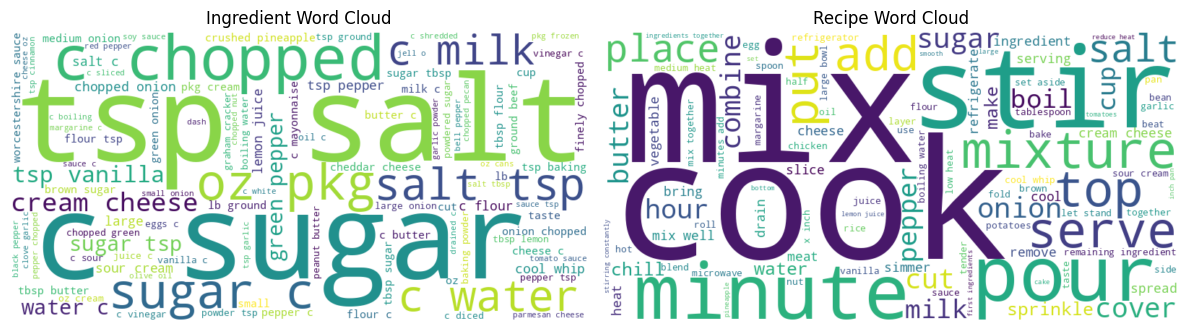


3. SENTENCE LENGTH STATISTICS
Average ingredient description length: 38.91 words (std dev: 17.28)
Average recipe length: 43.61 words (std dev: 25.64)


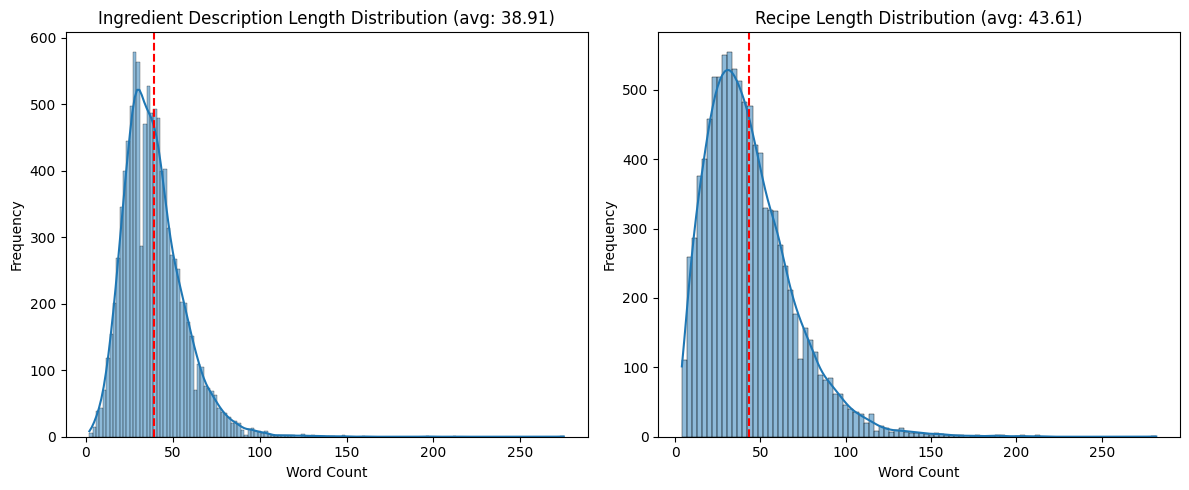


4. INGREDIENT COUNT STATISTICS
Average number of ingredients per recipe: 7.23 (std dev: 2.90)


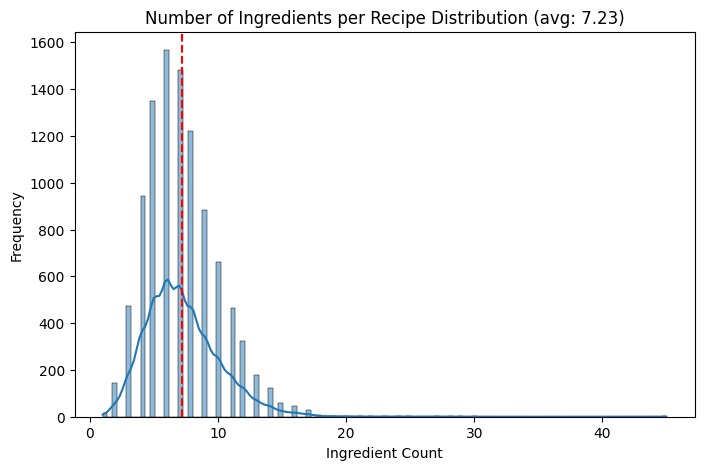


5. STEP COUNT STATISTICS
Average number of steps per recipe: 6.17 (std dev: 2.84)


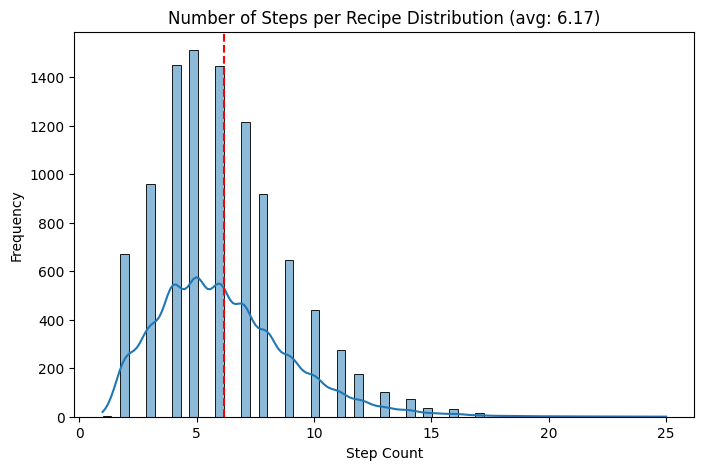


PREPROCESSING SUMMARY:
1. Text normalization: All text was converted to lowercase, and non-alphanumeric characters were removed
2. Punctuation handling: Periods, exclamation marks, and question marks were preserved with spaces added before them
3. Special tokens: Added SOS (start of sequence), EOS (end of sequence), UNK (unknown word), and PAD (padding) tokens
4. Sequence length: Maximum sequence length is limited to 100; longer sequences will be truncated and shorter ones will be padded

Example of normalized training pairs (first 3):
Ingredients: 1 c . firmly packed brown sugar 1 2 c . evaporated milk 1 2 tsp . vanilla 1 2 c ...
Recipe:  in a heavy 2 quart saucepan mix brown sugar nuts evaporated milk and butter or ...

Ingredients: 2 16 oz . pkg . frozen corn 1 8 oz . pkg . cream cheese cubed 1 3 c . butter cub...
Recipe:  in a slow cooker combine all ingredients . cover and cook on low for 4 hours or...

Ingredients: 1 c . peanut butter 3 4 c . graham cracker crumbs 1 c . melted b

In [ ]:
# --- 6. DATA STATISTICS (AFTER PREPROCESSING) ---
print("\n=== DATA STATISTICS FOR PREPROCESSED TRAINING SET (LIMITED TO 10,000 SAMPLES) ===")

# 1. Sample Count Statistics
print("\n1. SAMPLE COUNT STATISTICS")
train_count = len(train_data)
limited_train_count = len(train_data_limited)
dev_count = len(dev_data)
test_count = len(test_data)
total_count = train_count + dev_count + test_count
train_percentage = limited_train_count / train_count * 100

print(f"Full training set samples: {train_count}")
print(f"Limited training set samples: {limited_train_count} ({train_percentage:.1f}% of full training set)")
print(f"Development set samples: {dev_count} ({dev_count/total_count*100:.1f}% of all data)")
print(f"Test set samples: {test_count} ({test_count/total_count*100:.1f}% of all data)")
print(f"Total samples across all sets: {total_count}")

# 2. Vocabulary Size Statistics & Word Frequency
print("\n2. VOCABULARY SIZE STATISTICS")
print(f"Ingredients vocabulary size: {input_lang.n_words} unique words")
print(f"Recipe vocabulary size: {output_lang.n_words} unique words")

# Create word frequency statistics from the limited training set
ingredient_words = []
recipe_words = []

for i, row in train_data_limited.iterrows():
    ingredient_words.extend(row['Ingredients_norm'].split())
    recipe_words.extend(row['Recipe_norm'].split())

# Word frequency analysis
ingredient_counter = Counter(ingredient_words)
recipe_counter = Counter(recipe_words)

# Output top frequent words
print("\nTop 10 most frequent ingredient words:")
for word, count in ingredient_counter.most_common(10):
    print(f"  {word}: {count} occurrences")

print("\nTop 10 most frequent recipe words:")
for word, count in recipe_counter.most_common(10):
    print(f"  {word}: {count} occurrences")

# Generate and display word clouds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ingredient_wordcloud = WordCloud(width=800, height=400,
                                background_color='white',
                                max_words=100).generate(' '.join(ingredient_words))
plt.imshow(ingredient_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ingredient Word Cloud')

plt.subplot(1, 2, 2)
recipe_wordcloud = WordCloud(width=800, height=400,
                            background_color='white',
                            max_words=100).generate(' '.join(recipe_words))
plt.imshow(recipe_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Recipe Word Cloud')

plt.tight_layout()
plt.show()

# 3. Sentence Length Statistics
print("\n3. SENTENCE LENGTH STATISTICS")
ingredient_lengths = [len(row['Ingredients_norm'].split())
                     for _, row in train_data_limited.iterrows()]
recipe_lengths = [len(row['Recipe_norm'].split())
                 for _, row in train_data_limited.iterrows()]

# Calculate average lengths and standard deviations
avg_ing_len = np.mean(ingredient_lengths)
std_ing_len = np.std(ingredient_lengths)
avg_recipe_len = np.mean(recipe_lengths)
std_recipe_len = np.std(recipe_lengths)

print(f"Average ingredient description length: {avg_ing_len:.2f} words (std dev: {std_ing_len:.2f})")
print(f"Average recipe length: {avg_recipe_len:.2f} words (std dev: {std_recipe_len:.2f})")

# Plot length distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(ingredient_lengths, kde=True)
plt.axvline(avg_ing_len, color='r', linestyle='--')
plt.title(f'Ingredient Description Length Distribution (avg: {avg_ing_len:.2f})')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(recipe_lengths, kde=True)
plt.axvline(avg_recipe_len, color='r', linestyle='--')
plt.title(f'Recipe Length Distribution (avg: {avg_recipe_len:.2f})')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Ingredient Count Statistics
print("\n4. INGREDIENT COUNT STATISTICS")
# Use the original Ingredients list to calculate ingredient count per recipe
ingredient_counts = [len(row['Ingredients']) for _, row in train_data_limited.iterrows()]
avg_ingredient_count = np.mean(ingredient_counts)
std_ingredient_count = np.std(ingredient_counts)

print(f"Average number of ingredients per recipe: {avg_ingredient_count:.2f} (std dev: {std_ingredient_count:.2f})")

# Plot ingredient count distribution
plt.figure(figsize=(8, 5))
sns.histplot(ingredient_counts, kde=True)
plt.axvline(avg_ingredient_count, color='r', linestyle='--')
plt.title(f'Number of Ingredients per Recipe Distribution (avg: {avg_ingredient_count:.2f})')
plt.xlabel('Ingredient Count')
plt.ylabel('Frequency')
plt.show()

# 5. Step Count Statistics (estimated by sentence separators)
print("\n5. STEP COUNT STATISTICS")
# Use periods as separators to estimate number of steps
step_counts = []
for _, row in train_data_limited.iterrows():
    recipe = row['Recipe']
    # Split by periods, exclamation marks, and question marks to count steps
    steps = re.split(r'[.!?]+', recipe)
    # Filter out empty strings
    steps = [s.strip() for s in steps if s.strip()]
    step_counts.append(len(steps))

avg_step_count = np.mean(step_counts)
std_step_count = np.std(step_counts)

print(f"Average number of steps per recipe: {avg_step_count:.2f} (std dev: {std_step_count:.2f})")

# Plot step count distribution
plt.figure(figsize=(8, 5))
sns.histplot(step_counts, kde=True)
plt.axvline(avg_step_count, color='r', linestyle='--')
plt.title(f'Number of Steps per Recipe Distribution (avg: {avg_step_count:.2f})')
plt.xlabel('Step Count')
plt.ylabel('Frequency')
plt.show()

# Data preprocessing description
print("\nPREPROCESSING SUMMARY:")
print("1. Text normalization: All text was converted to lowercase, and non-alphanumeric characters were removed")
print("2. Punctuation handling: Periods, exclamation marks, and question marks were preserved with spaces added before them")
print("3. Special tokens: Added SOS (start of sequence), EOS (end of sequence), UNK (unknown word), and PAD (padding) tokens")
print("4. Sequence length: Maximum sequence length is limited to 100; longer sequences will be truncated and shorter ones will be padded")

# --- 7. TENSOR CREATION FUNCTIONS ---
def indexesFromSentence(lang, sentence):
    # Convert a sentence to a list of indices
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence, max_length=MAX_LENGTH):
    # Convert a sentence to a tensor with padding
    indexes = indexesFromSentence(lang, sentence)
    # Truncate if too long
    if len(indexes) > max_length - 1:  # -1 to account for EOS token
        indexes = indexes[:max_length-1]
    indexes.append(EOS_token)
    # Pad if too short
    padding = [PAD_token] * (max_length - len(indexes))
    indexes.extend(padding)
    return torch.tensor(indexes, dtype=torch.long, device=device)

# Prepare training pairs from limited data
train_pairs_limited = [(row['Ingredients_norm'], row['Recipe_norm']) for _, row in train_data_limited.iterrows()]
dev_pairs = [(row['Ingredients_norm'], row['Recipe_norm']) for _, row in dev_data.iterrows()]

# Display a few examples of normalized pairs
print("\nExample of normalized training pairs (first 3):")
for i in range(min(3, len(train_pairs_limited))):
    print(f"Ingredients: {train_pairs_limited[i][0][:80]}...")
    print(f"Recipe: {train_pairs_limited[i][1][:80]}...")
    print()

In [ ]:
# --- 8. DATASET CLASS ---
class RecipeDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang, max_length=MAX_LENGTH):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        input_tensor = tensorFromSentence(self.input_lang, pair[0], self.max_length)
        target_tensor = tensorFromSentence(self.output_lang, pair[1], self.max_length)
        return input_tensor, target_tensor

# Create datasets and dataloaders
train_dataset = RecipeDataset(train_pairs_limited, input_lang, output_lang)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

dev_dataset = RecipeDataset(dev_pairs, input_lang, output_lang)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

In [ ]:
# --- 9. ENCODER MODEL ---
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        # Forward pass through the encoder
        batch_size = input.size(0)

        # Embedding: [batch_size, seq_len] -> [batch_size, seq_len, hidden_size]
        embedded = self.embedding(input)

        # Initialize hidden if None
        if hidden is None:
            hidden = self.initHidden(batch_size)

        # GRU forward pass
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# --- 10. DECODER MODEL ---
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        # Forward pass through the decoder

        # Ensure input has the right shape: [batch_size, seq_len]
        if input.dim() == 1:
            input = input.unsqueeze(1)  # Add sequence dimension

        # Embedding: [batch_size, seq_len] -> [batch_size, seq_len, hidden_size]
        embedded = self.embedding(input)

        # Apply ReLU activation
        output = F.relu(embedded)

        # GRU forward pass
        output, hidden = self.gru(output, hidden)

        # Apply linear layer and softmax to get log probabilities
        output = self.softmax(self.out(output))

        return output, hidden

    def initHidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# Initialize models
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

# Define optimizer and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index=PAD_token, reduction='sum')

In [ ]:
# --- 11. TRAINING FUNCTION ---
def train_batch(input_batch, target_batch, encoder, decoder,
               encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Train the model on a single batch
    batch_size = input_batch.size(0)

    # Zero the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Initialize loss
    loss = 0

    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(batch_size)

    # Process the input batch through the encoder
    encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

    # First decoder input is the SOS token for each item in the batch
    decoder_input = torch.tensor([SOS_token] * batch_size, device=device)

    # Set decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden

    # Determine whether to use teacher forcing
    use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False

    # Teacher forcing: use the ground-truth target as the next input
    if use_teacher_forcing:
        for di in range(target_batch.size(1)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Calculate loss for the current timestep
            loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

            # Next input is current target
            decoder_input = target_batch[:, di]

    # Without teacher forcing: use decoder's own prediction as the next input
    else:
        for di in range(target_batch.size(1)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Get the most likely word index
            topv, topi = decoder_output.squeeze(1).topk(1)
            decoder_input = topi.squeeze(1).detach()  # Detach from history as input

            # Calculate loss
            loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

            # Stop if all sequences in batch reached EOS
            if (decoder_input == EOS_token).all():
                break

    # Backpropagate
    loss.backward()

    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    # Update weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / batch_size

In [ ]:
# --- 12. EVALUATION FUNCTION ---
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # Generate a recipe from ingredients using the trained model
    with torch.no_grad():
        # Normalize the input sentence
        normalized_sentence = normalizeString(sentence)

        # Create a list of indices from the sentence and add EOS
        indexes = [input_lang.word2index.get(word, UNK_token) for word in normalized_sentence.split(' ')]
        if len(indexes) > max_length - 1:
            indexes = indexes[:max_length-1]
        indexes.append(EOS_token)

        # Create input tensor [seq_len]
        input_tensor = torch.tensor(indexes, dtype=torch.long, device=device)

        # Add batch dimension [1, seq_len]
        input_tensor = input_tensor.unsqueeze(0)

        # Initialize encoder hidden state
        encoder_hidden = encoder.initHidden(1)

        # Pass through the encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        # Initialize decoder input - single SOS token
        decoder_input = torch.tensor([[SOS_token]], device=device)  # [1, 1]

        decoder_hidden = encoder_hidden

        decoded_words = []

        # Step-by-step decoding
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Get the word with highest probability
            topv, topi = decoder_output.topk(1, dim=2)
            topi = topi.squeeze(-1)  # Remove the last dimension

            # Get word index
            word_idx = topi.item() if topi.numel() == 1 else topi[0].item()

            # Handle special tokens
            if word_idx == EOS_token:
                decoded_words.append('<EOS>')
                break
            elif word_idx == PAD_token:
                continue
            else:
                if word_idx < len(output_lang.index2word):
                    word = output_lang.index2word[word_idx]
                    decoded_words.append(word)
                else:
                    unk_word = f"<UNK-{word_idx}>"
                    decoded_words.append(unk_word)

            # Prepare the next input - keep shape [1, 1]
            decoder_input = torch.tensor([[word_idx]], device=device)

        # Combine the result
        result = ' '.join([word for word in decoded_words if word != '<EOS>'])
        return result

# --- 13. DEVELOPMENT EVALUATION FUNCTION ---
def develop(encoder, decoder, dataloader, criterion, max_length=MAX_LENGTH):
    # Evaluate the model on the development set
    encoder.eval()
    decoder.eval()

    total_loss = 0
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(dataloader):
            batch_size = input_batch.size(0)

            # Initialize encoder hidden state
            encoder_hidden = encoder.initHidden(batch_size)

            # Process the input batch through the encoder
            encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

            # First decoder input is the SOS token for each item in the batch
            decoder_input = torch.tensor([SOS_token] * batch_size, device=device)

            # Set decoder hidden state to the encoder's final hidden state
            decoder_hidden = encoder_hidden

            # Initialize loss
            loss = 0

            # Decode one step at a time
            for di in range(target_batch.size(1)):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Calculate loss
                loss += criterion(decoder_output.squeeze(1), target_batch[:, di])

                # Next input is ground truth
                decoder_input = target_batch[:, di]

            total_loss += loss.item() / batch_size

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
# --- 14. TRAINING LOOP ---
def train_epochs(encoder, decoder, train_dataloader, dev_dataloader,
               encoder_optimizer, decoder_optimizer, criterion,
               num_epochs, print_every=PRINT_EVERY, plot_every=PLOT_EVERY):
    # Train the model for multiple epochs
    start = time.time()
    train_losses = []
    dev_losses = []
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    best_dev_loss = float('inf')

    # Early Stopping
    patience = PATIENCE
    no_improve_count = 0

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()

        epoch_loss = 0
        batch_count = 0

        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            batch_count += 1

            # Train on this batch
            loss = train_batch(input_batch, target_batch, encoder, decoder,
                       encoder_optimizer, decoder_optimizer, criterion)

            # Accumulate loss
            print_loss_total += loss
            plot_loss_total += loss
            epoch_loss += loss

            # Update plot
            if batch_count % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} complete | Average Loss: {avg_epoch_loss:.4f}")

        # Develop
        dev_loss = develop(encoder, decoder, dev_dataloader, criterion)
        print(f"Development Loss: {dev_loss:.4f}")

        # Store losses for plotting
        train_losses.append(avg_epoch_loss)
        dev_losses.append(dev_loss)

        # Early Stopping
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            no_improve_count = 0
            print(f"New best development loss: {dev_loss:.4f}")

            # Save best model
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
            }, f"{file_path}/baseline1_best_model.pt")
            print("Best model saved.")
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    # Show the loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(dev_losses) + 1), dev_losses, 'r-', label='Development Loss')
    plt.title('Training and Development Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file_path}/loss_plot.png")
    plt.show()

    time_taken = time.time() - start
    print(f"Training completed in {time_taken/60:.2f} minutes")

    return train_losses, dev_losses

In [ ]:
# --- 15. EVALUATION METRICS ---
def calculate_metrics(reference, hypothesis):
    # Calculate BLEU-4, METEOR, and BERTScore metrics
    try:
        # Tokenize for metrics calculation
        ref_tokens = nltk.word_tokenize(reference)
        hyp_tokens = nltk.word_tokenize(hypothesis)

        # BLEU-4 with smoothing
        smoothie = SmoothingFunction().method4
        bleu = sentence_bleu([ref_tokens], hyp_tokens,
                            weights=(0.25, 0.25, 0.25, 0.25),
                            smoothing_function=smoothie)

        # METEOR
        meteor = meteor_score([ref_tokens], hyp_tokens)

        # BERTScore
        P, R, F1 = bert_score([hypothesis], [reference], lang='en', verbose=False)
        bertscore = F1.numpy().item()

        return bleu, meteor, bertscore

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return 0.0, 0.0, 0.0


Starting training...
Epoch 1/30 complete | Average Loss: 229.1178
Development Loss: 174.4710
New best development loss: 174.4710
Best model saved.
Epoch 2/30 complete | Average Loss: 204.8276
Development Loss: 156.3709
New best development loss: 156.3709
Best model saved.
Epoch 3/30 complete | Average Loss: 193.8588
Development Loss: 148.3239
New best development loss: 148.3239
Best model saved.
Epoch 4/30 complete | Average Loss: 188.0303
Development Loss: 143.1858
New best development loss: 143.1858
Best model saved.
Epoch 5/30 complete | Average Loss: 183.6941
Development Loss: 140.2963
New best development loss: 140.2963
Best model saved.
Epoch 6/30 complete | Average Loss: 180.7375
Development Loss: 138.1845
New best development loss: 138.1845
Best model saved.
Epoch 7/30 complete | Average Loss: 175.0309
Development Loss: 136.6447
New best development loss: 136.6447
Best model saved.
Epoch 8/30 complete | Average Loss: 177.8132
Development Loss: 136.3206
New best development los

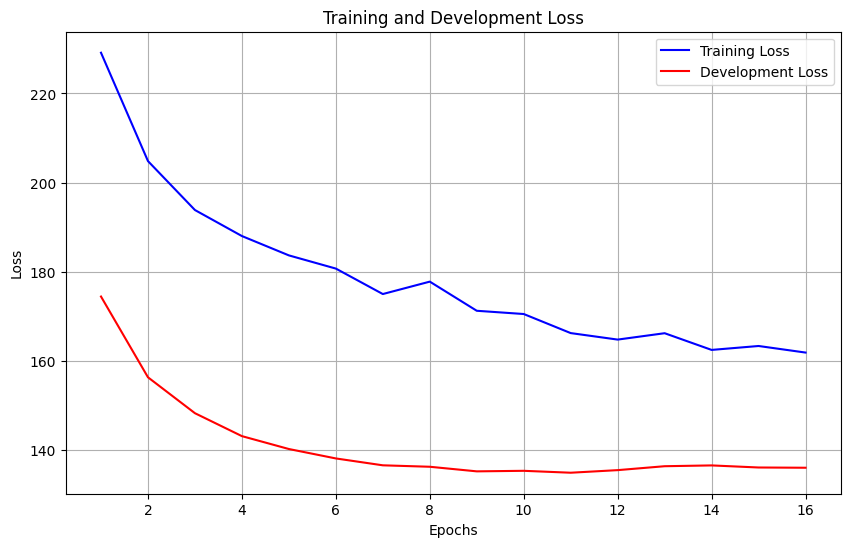

Training completed in 24.89 minutes


In [ ]:
# --- 16. MAIN EXECUTION BLOCK ---
# Start training
print("\nStarting training...")
train_losses, dev_losses = train_epochs(
    encoder, decoder, train_dataloader, dev_dataloader,
    encoder_optimizer, decoder_optimizer, criterion,
    NUM_EPOCHS, PRINT_EVERY, PLOT_EVERY
)

In [ ]:
# Save final model
torch.save({
   'encoder_state_dict': encoder.state_dict(),
   'decoder_state_dict': decoder.state_dict(),
}, f"{file_path}/baseline1_final_model.pt")
print("Final model saved.")

Final model saved.


In [ ]:
# Evaluate on test data
print("\nEvaluating on test data...")

# Decide whether to use a subset of test data for evaluation
if USE_SMALL_TEST:
   # Use only the first 10 samples
   test_subset = test_data[:10]
   print(f"Using {len(test_subset)} test samples for evaluation (development mode)")
else:
   # Use all test data
   test_subset = test_data
   print(f"Using all {len(test_data)} test samples for evaluation (production mode)")

# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Initialize lists to store results
test_results = []
bleu_scores = []
meteor_scores = []
bertscore_scores = []

# Process test data
for idx, row in test_subset.iterrows():
   ingredients_text = row['Ingredients_text']
   original_recipe = row['Recipe']

   # Generate recipe
   generated_recipe = evaluate(encoder, decoder, ingredients_text)

   # Normalize original recipe for evaluation
   normalized_recipe = normalizeString(original_recipe)

   # Calculate metrics
   bleu, meteor, bertscore = calculate_metrics(normalized_recipe, generated_recipe)

   # Store results
   test_results.append({
       'ingredients': ingredients_text,
       'original_recipe': original_recipe,
       'generated_recipe': generated_recipe,
       'bleu': bleu,
       'meteor': meteor,
       'bertscore': bertscore
   })

   # Accumulate scores for averaging
   bleu_scores.append(bleu)
   meteor_scores.append(meteor)
   bertscore_scores.append(bertscore)

   # Print progress every 100 samples
   if (idx + 1) % 100 == 0:
       print(f"Processed {idx + 1}/{len(test_subset)} test samples")

# Convert results to DataFrame
results_df = pd.DataFrame(test_results)

# Save results
results_df.to_csv(f"{file_path}/baseline1_results.csv", index=False)
print("Results saved to CSV file.")

# Calculate average metrics
avg_bleu = np.mean(bleu_scores)
avg_meteor = np.mean(meteor_scores)
avg_bertscore = np.mean(bertscore_scores)

print("\nBaseline 1 Evaluation Results:")
print(f"BLEU-4 Score: {avg_bleu:.4f}")
print(f"METEOR Score: {avg_meteor:.4f}")
print(f"BERTScore (F1): {avg_bertscore:.4f}")


Evaluating on test data...
Using all 1081 test samples for evaluation (production mode)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Processed 100/1081 test samples


Processed 200/1081 test samples


Processed 300/1081 test samples


Processed 400/1081 test samples


Processed 500/1081 test samples


Processed 600/1081 test samples


Processed 700/1081 test samples


Processed 800/1081 test samples


Processed 900/1081 test samples


Processed 1000/1081 test samples


Results saved to CSV file.

Baseline 1 Evaluation Results:
BLEU-4 Score: 0.0142
METEOR Score: 0.1112
BERTScore (F1): 0.7650


In [ ]:
# Qualitative comparison test for presentation
print("\n=== Qualitative Comparison for Presentation ===")

# Test Sample 1
sample1 = "sugar, lemon juice, water, orange juice, strawberries, icecream"
result1 = evaluate(encoder, decoder, sample1)
words1 = " ".join(result1.split()[:30])
print("\nSample 1:")
print(f"Ingredients: {sample1}")
print(f"First 30 words: {words1}")

# Test Sample 2
sample2 = "8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c lemon juice, 48 oz canned cherries, 8 inch graham cracker, pie crusts"
result2 = evaluate(encoder, decoder, sample2)
words2 = " ".join(result2.split()[:30])
print("\nSample 2:")
print(f"Ingredients: {sample2}")
print(f"First 30 words: {words2}")

# Save
with open(f"{file_path}/qualitative_results_baseline1.txt", "w") as f:
   f.write(f"Sample 1 (Baseline 1): {words1}\n\n")
   f.write(f"Sample 2 (Baseline 1): {words2}\n")

print("\nResults saved to file.")


=== Qualitative Comparison for Presentation ===

Sample 1:
Ingredients: sugar, lemon juice, water, orange juice, strawberries, icecream
First 30 words: kool aid freeze it sticks and solid in 1 2 cup cold water .

Sample 2:
Ingredients: 8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c lemon juice, 48 oz canned cherries, 8 inch graham cracker, pie crusts
First 30 words: whip cream cheese and powdered sugar . fold in cool whip . spread on top of pie filling . sprinkle with nuts . freeze .

Results saved to file.
